In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image
from numpy import asarray
import glob
import cv2
import tensorflow as tf
from tensorflow import keras

## Import Data

### Train.csv

In [2]:
all_labels=pd.read_csv('train.csv')

In [3]:
Labels_DF=pd.DataFrame(all_labels)
Labels_DF.rename(columns={'image':'file_name'}, inplace=True)
Labels_DF.head(3)

,file_name,species,individual_id
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9
1,000562241d384d.jpg,humpback_whale,1a71fbb72250
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b


In [ ]:
#Labels_DF['species'].value_counts()

In [4]:
## species with incorrect spellings.  bottlenose_dolpin, kiler_whale.
Labels_DF['species'].replace('bottlenose_dolpin', 'bottlenose_dolphin', inplace=True)
Labels_DF['species'].replace('kiler_whale', 'killer_whale', inplace=True)

In [5]:
## create subcategory for whale or dolphin
sub=[]
for each in Labels_DF['species']:
    if 'dolphin' in each:
        a=0
    else: a=1
    sub.append(a)

In [6]:
Labels_DF['sub_cat']=sub

In [7]:
## create species cat numerical
from sklearn.preprocessing import OrdinalEncoder
OE=OrdinalEncoder()
SE=OE.fit_transform(Labels_DF[['species']])
Labels_DF['species_category']=SE.astype(int)

In [52]:
Labels_DF.head(6)

,file_name,species,individual_id,sub_cat,species_category
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9,whale,16
1,000562241d384d.jpg,humpback_whale,1a71fbb72250,whale,13
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b,whale,8
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063,dolphin,2
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392,whale,13
5,000a8f2d5c316a.jpg,bottlenose_dolphin,b9907151f66e,dolphin,2


In [8]:
len(Labels_DF['species_category'].value_counts())

28

In [9]:
Labels_DF['species_category'].value_counts()

2     10781
0      7443
13     7392
1      4830
8      3326
7      3139
14     2455
25     1700
16     1689
17     1608
9      1324
12     1123
24      866
26      490
22      428
23      367
5       347
6       341
19      262
15      238
27      229
3       154
18      145
11      116
4        90
20       76
21       60
10       14
Name: species_category, dtype: int64

In [9]:
Species_Key=pd.DataFrame({
    'Species': Labels_DF['species'].unique(),
    'Key': Labels_DF['species_category'].unique()
})

In [ ]:
Species_Key

### Images

In [10]:
# get images
image_list = []
for filename in glob.glob('SmallSample/*.jpg'):
    im=Image.open(filename)
    image_list.append(im)

In [11]:
# file name for each image
image_names = []
for filename in glob.glob('SmallSample/*.jpg'):
    name=filename.strip('SmallSample\\')
    image_names.append(name)

In [12]:
len(image_list), len(image_names)

(152, 152)

In [13]:
Image_DF=pd.DataFrame({
    'image': image_list,
    'file_name': image_names
    })

In [102]:
## Join Dataframes

Big_DF=Image_DF.merge(Labels_DF, how='outer')

In [103]:
Big_DF=Big_DF[:152]
Big_DF.tail(5)

,image,file_name,species,individual_id,sub_cat,species_category
147,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0a99ad33a87739.jpg,blue_whale,ea1dbc9f1f36,1,1
148,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0a99cbb091b9b8.jpg,humpback_whale,d1f90ae774ca,1,13
149,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0a9c11c6d8d9e6.jpg,humpback_whale,f70cb8952cad,1,13
150,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0a9daef82ebe79.jpg,dusky_dolphin,62ac9c194888,0,7
151,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0a9f092e4e3e92.jpg,humpback_whale,51ccb281b87c,1,13


### Create train/val Dataset

#### Shuffle and split dataset

In [104]:
from sklearn.model_selection import train_test_split

y=Big_DF['sub_cat']
X=Big_DF['image']

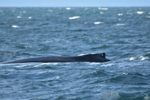

In [105]:
X[2]

In [106]:
for each in X:
    each.thumbnail((150,150))

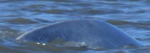

In [107]:
X[3]

In [112]:
from PIL import ImageOps
reshaped_img=[]
size=(200,150)

for each in X:
    i=ImageOps.fit(each, size, Image.ANTIALIAS)
    reshaped_img.append(i)
    

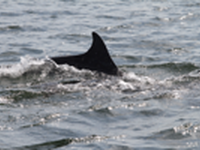

In [114]:
reshaped_img[9]

In [115]:
arrays=[]

for each in reshaped_img:
    a=asarray(each)
    arrays.append(a)

In [116]:
norm_arrays=[]

for each in arrays:
    e=each/255
    norm_arrays.append(e)

In [117]:
norm_arrays[7].shape

(150, 200, 3)

In [118]:
# One hot encode labels

from keras.utils import to_categorical

y_hot=to_categorical(y)

y_hot[:6]

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [119]:
X_train, X_val, y_train, y_val= train_test_split(norm_arrays,y_hot, train_size=.80, stratify=y)

## Data Prep

In [120]:
y_train.shape, len(X_train)

((121, 2), 121)

In [121]:
# One array is 2d

X_array=np.array(X_train)

ValueError: could not broadcast input array from shape (150,200,3) into shape (150,200)

In [91]:
from tensorflow.keras import layers
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

model = keras.models.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(150,200,3),padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))                  
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='linear'))
model.add(LeakyReLU(alpha=0.1))                  
model.add(Dense(2, activation='softmax'))

In [92]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [93]:
model.fit(X_train, y_train,batch_size=30, epochs=5)

ValueError: Data cardinality is ambiguous:
  x sizes: 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150
  y sizes: 121
Please provide data which shares the same first dimension.

## Separate Dolphins into species of Dolphin

In [ ]:
Dolphins_Species=pd.DataFrame(Labels_DF.loc[Labels_DF['sub_cat']==1])

In [ ]:
Dolphins_Species['species_category'].value_counts()

#### Consider combining categories with low counts for better training when trying to identify individuals

In [ ]:
len(Labels_DF['individual_id'].unique())

####  15,587 unique individuals in entire data set (dolphins and whales) 51,000 images.  Cannot make individual id files.
####  Species category 10 has 13 unique individuals out of 14 instances.